In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

In [2]:
from dsp.pll import PLL, PLL_2, PLL_3
from dsp.fir import WSFilter
from dsp.fm import FMDemodulator
from dsp.am import AMDemodulator
from exp_utils import read_iq, read_real, welch

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import os
from os.path import join
root_path = os.getenv('RADIO_PATH', '.')

# RDS

### Physical layer.

First, we need to take FM-demodulated signal and lock on to 19 kHz pilot tone by applying a phase-locked loop. Then we need to bandpass filter the signal and use the frequency and phase of our PLL to AM-demodulate 57 kHz signal. 

In [5]:
from scipy.signal import butter, lfilter


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [6]:
# source: rtl_fm -M fm -s 171000 -f 104105000
data_path = join(root_path, './data/rds')
rds = read_real(data_path, dtype=np.int16).astype(np.double)

In [7]:
sample_rate_fm = 240000
rds_band = butter_bandpass_filter(rds, 56800, 57200, sample_rate_fm)

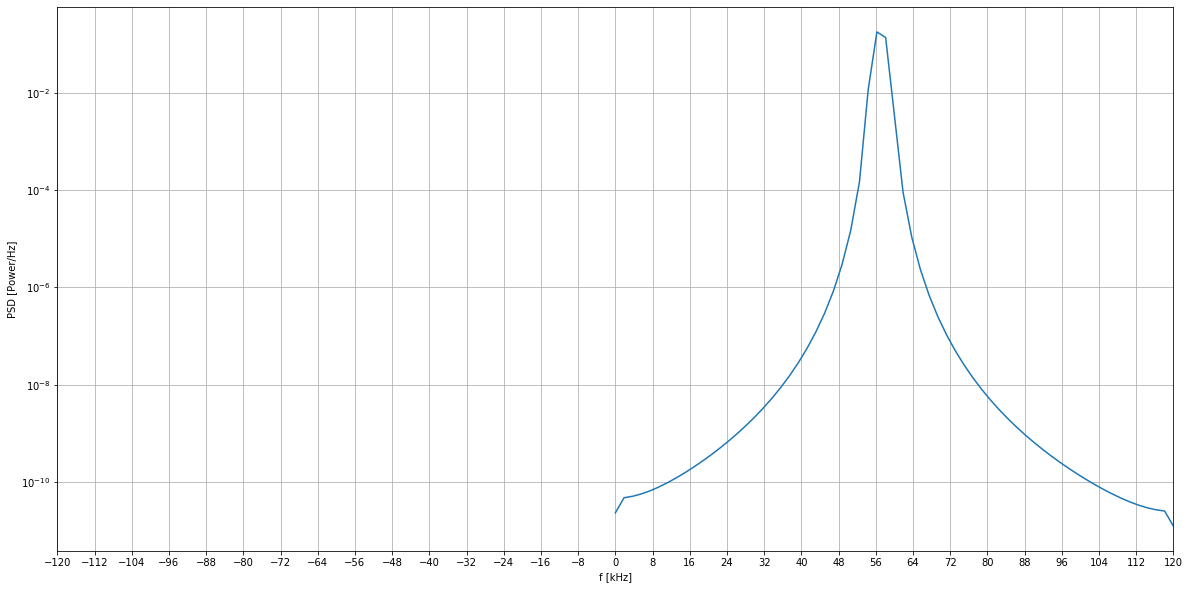

In [8]:
welch(rds_band, sample_rate_fm, nper=128)

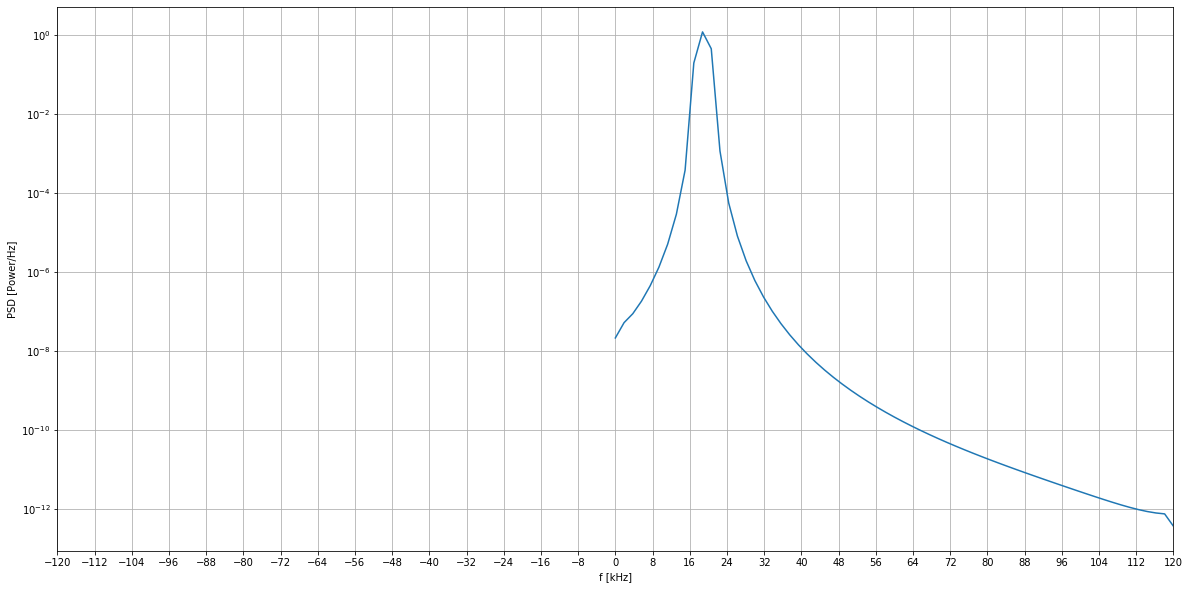

In [9]:
pilot_band = butter_bandpass_filter(rds, 18900, 19100, sample_rate_fm)
welch(pilot_band, sample_rate_fm, nper=128)

In [10]:
fq, fs = 19000, 240000
ref_phases = [np.mod(2 * np.pi * fq / fs * n + np.pi, 2 * np.pi) for n in range(pilot_band.shape[0])]
ref_pilot = np.array([np.cos(p) for p in ref_phases])

In [11]:
pll2 = PLL_2(fq=1, fs=15, Bn=0.15)
locked_ref_phases2, _, _ = pll2.run(ref_pilot)
locked_ref2 = np.array([np.cos(p) for p in locked_ref_phases2])

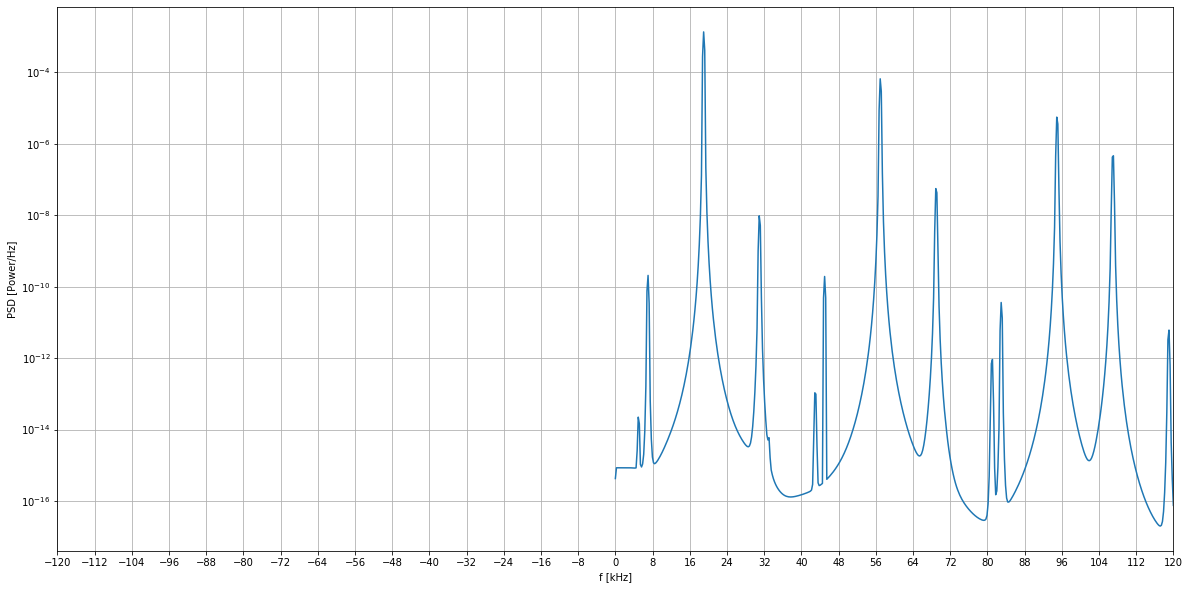

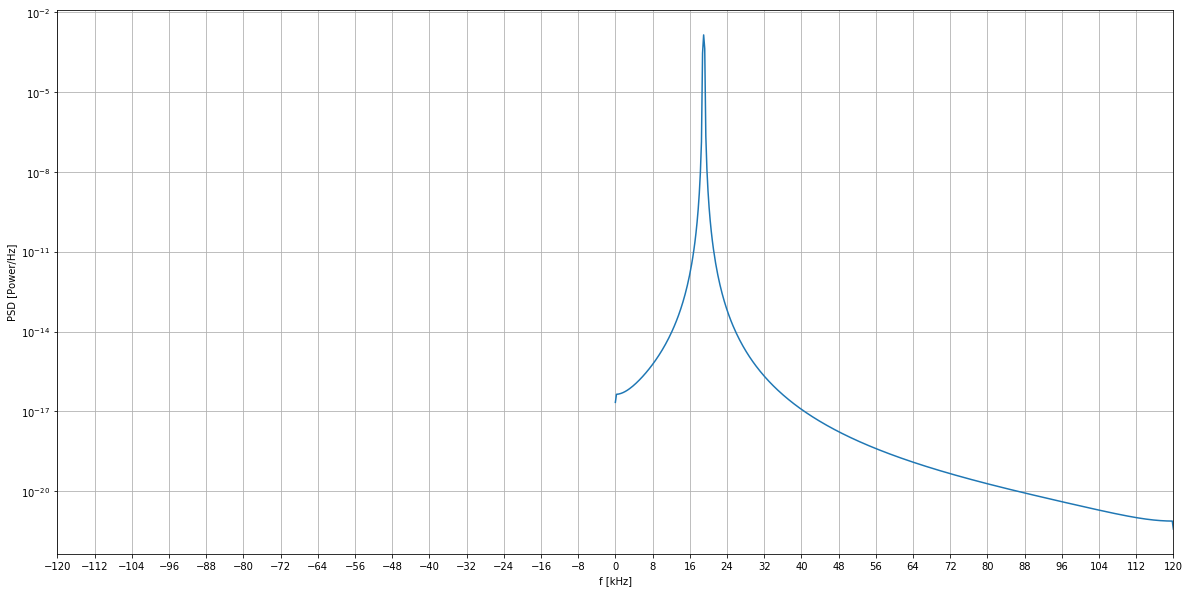

In [12]:
welch(locked_ref2, sample_rate_fm)
welch(ref_pilot, sample_rate_fm)

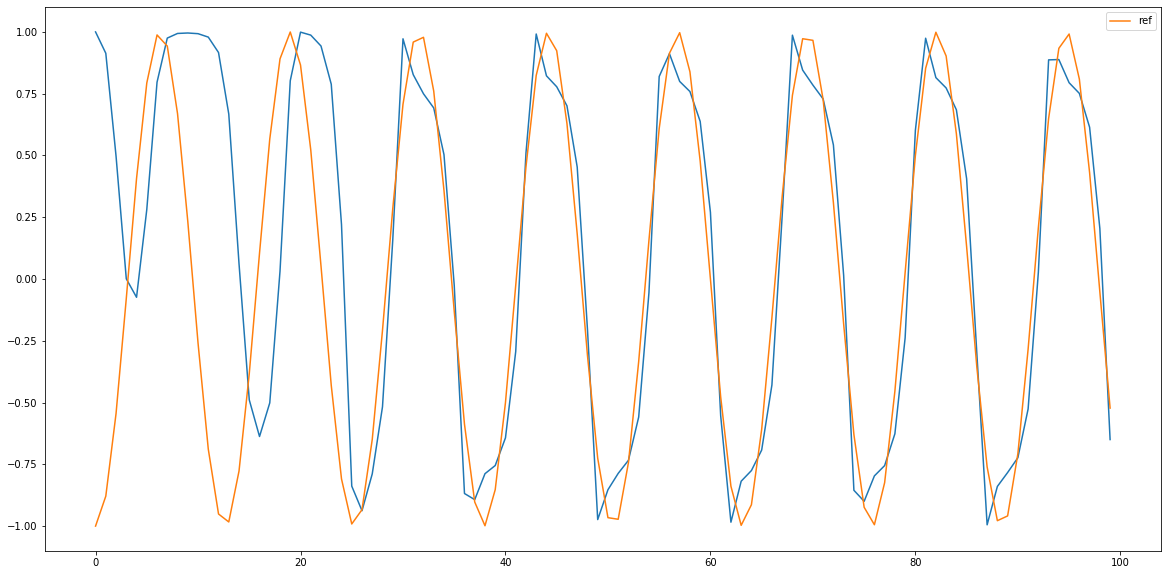

In [13]:
l = 0
r = l + 100
plt.figure(figsize=(20, 10))
plt.plot(locked_ref2[l:r])
plt.plot(ref_pilot[l:r], label='ref')
#plt.plot(phases[l:r] - ref_phases[l:r])
plt.legend()

In [14]:
locked_pilot_phases2, _, _ = pll2.run(pilot_band)

In [15]:
locked_pilot2 = np.array([np.cos(p) for p in locked_ref_phases2])

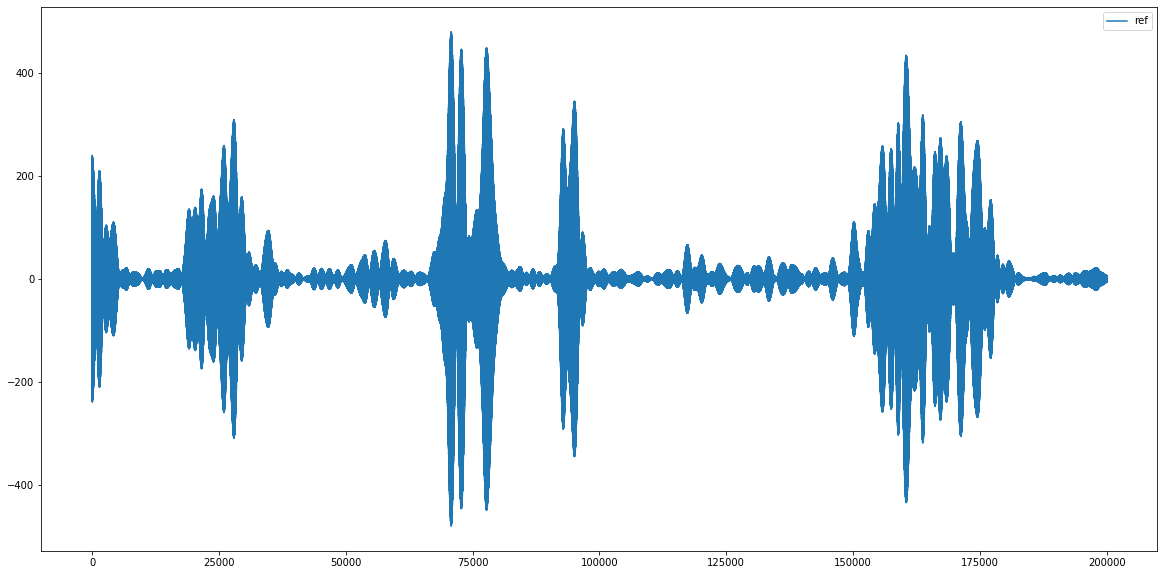

In [16]:
l = 20000
r = l + 200000
plt.figure(figsize=(20, 10))
#plt.plot(locked_pilot2[l:r])
plt.plot(pilot_band[l:r], label='ref')
#plt.plot(phases[l:r] - ref_phases[l:r])
plt.legend()

In [17]:
reference_rds_carrier = np.array([np.cos(3 * p) for p in locked_pilot_phases2])
reference_pilot = np.array([np.cos(p) for p in locked_pilot_phases2])

In [18]:
M = 1
am_demod = AMDemodulator(2400, 240000, M, agc=False)
rds_demod = am_demod.run(rds_band, reference_rds_carrier)

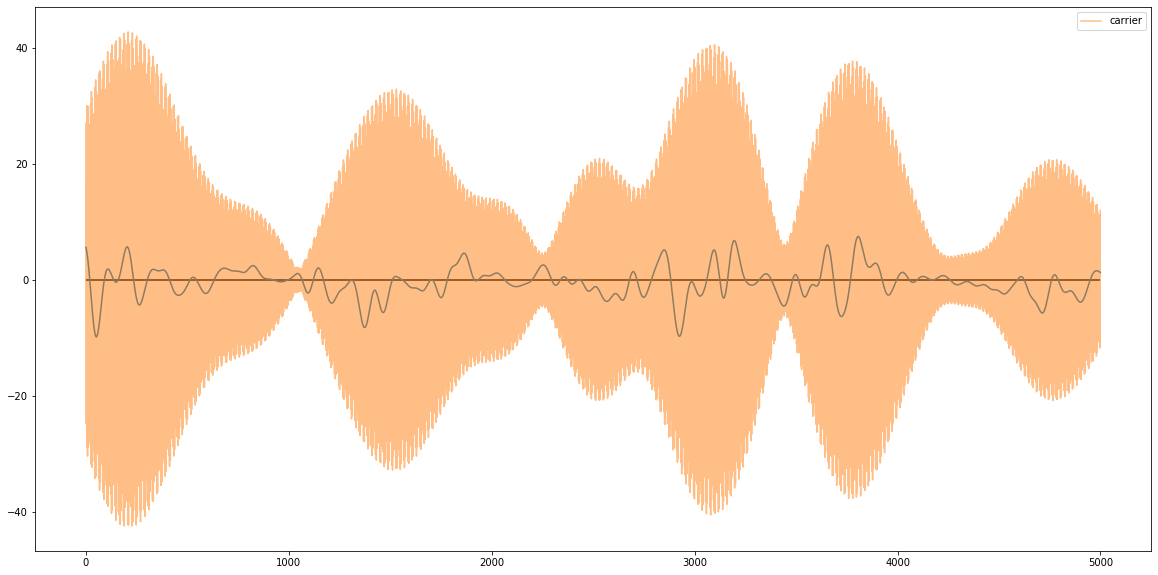

In [19]:
# TODO: apply AGC on pilot
l = 20000
size = 5000
r = l + size
plt.figure(figsize=(20, 10))
plt.plot(rds_demod[l:r])
#plt.plot(0.1 * reference_pilot[l:r])
plt.plot(rds_band[M * l:M * r:M], label='carrier', alpha=0.5)
plt.hlines(0, 0, size)
plt.legend()

Now *rds_demod* contains pulse-shaped, differentially encoded biphase signal. It should be filtered with a matched **root-raised-cosine** filter. Then we should actually retrieve the differentially encoded signal from pulse-shaped biphase symbols.

We already have appropriate symbol frequency in *reference_rds_clock*, but we still lack the **timing offset**. That is, we don't know where the symbols actually begin and end, though we (moreless) know how frequently that occurs. We need some DSP magic loop that could adjust *reference_rds_clock* phase so that we can recover the original symbols as accurately as possible.


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from dsp.decoding import SymbolDecoder

In [21]:
symbol_rate = 2375
sample_rate = 2400
samples_per_symbol = sample_rate / symbol_rate
output_samples_per_symbol = 1
symbol_delay = 3
filterbank_size = 32
matched_filter_rolloff = 0.8
Bn = 0.01

sd = SymbolDecoder(
    sample_rate,
    samples_per_symbol,
    output_samples_per_symbol,
    symbol_delay,
    filterbank_size, 
    matched_filter_rolloff,
    Bn
)

In [22]:
symbols = sd.run(rds_demod)
symbols = symbols[0]

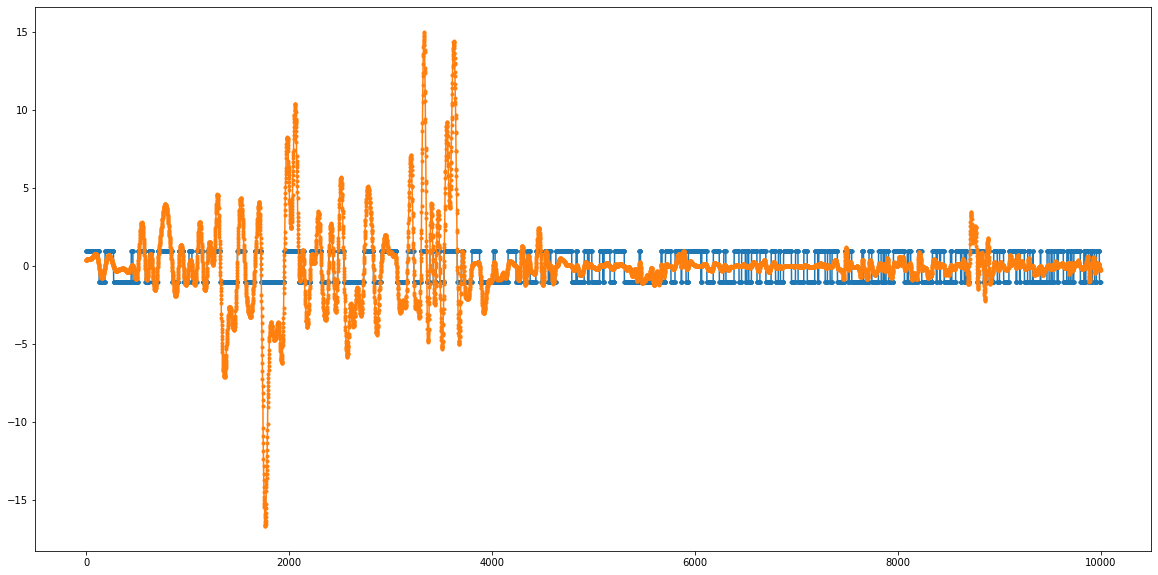

In [23]:
l = 50
step = 10000
r = l + step
plt.figure(figsize=(20, 10))
plt.plot(np.sign(symbols[l:r]), '.-')
plt.plot(0.1 * symbols[l:r], '.-')

Then we need to take the demodulated signal and turn it into a bit stream. That encompasses biphase symbol decoding and then differential decoding.